### 목표 : auto_mpg 연비 분석
- 2024/02/28 과제
- 데이터 : https://www.kaggle.com/datasets/uciml/autompg-dataset?resource=download
- 학습방법 : 지도학습 + 예측 => Linear Regression or KNN Regression (Y값이 연속형이라서)

데이터 준비

In [1]:
import pandas as pd

In [2]:
filename = 'auto-mpg.csv'
mpgDF = pd.read_csv(filename)
mpgDF

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


데이터 전처리
- 이상치, 결측치, 중복값

In [3]:
# 타겟 : mpg
# 피쳐 : [후보] cylinders, displacement, horsepower, weight, acceleration, model year
mpgDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
mpgDF['horsepower'].unique()    # '?' 존재 -> 그래서 타입이 object

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [5]:
question_mark = mpgDF['horsepower'] == '?'
mpgDF[question_mark]    # 6개 행 존재 -> 전체 데이터 수 : 398, 비율이 작으므로 분석에서 제외

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [6]:
tempDF = mpgDF[~question_mark]

# tempDF['horsepower'] = pd.to_numeric(tempDF['horsepower'], errors='coerce')   # If ‘coerce’, then invalid parsing will be set as NaN.
# tempDF.dropna(inplace=True)
tempDF.loc[:, 'horsepower'] = tempDF['horsepower'].astype('int')
tempDF.reset_index(drop=True, inplace=True)
tempDF.index, tempDF.shape

(RangeIndex(start=0, stop=392, step=1), (392, 9))

In [7]:
tempDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 27.7+ KB


In [8]:
import matplotlib.pyplot as plt

def print_features(nrows, ncols, DF, target, features):
    corrDF = DF[[target] + features].corr()
    plt.figure(figsize=(10, 2 * nrows))
    
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx+1)
        plt.scatter(DF[target], DF[features[idx]], label=f'{corrDF[target].loc[features[idx]]:.2f}')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

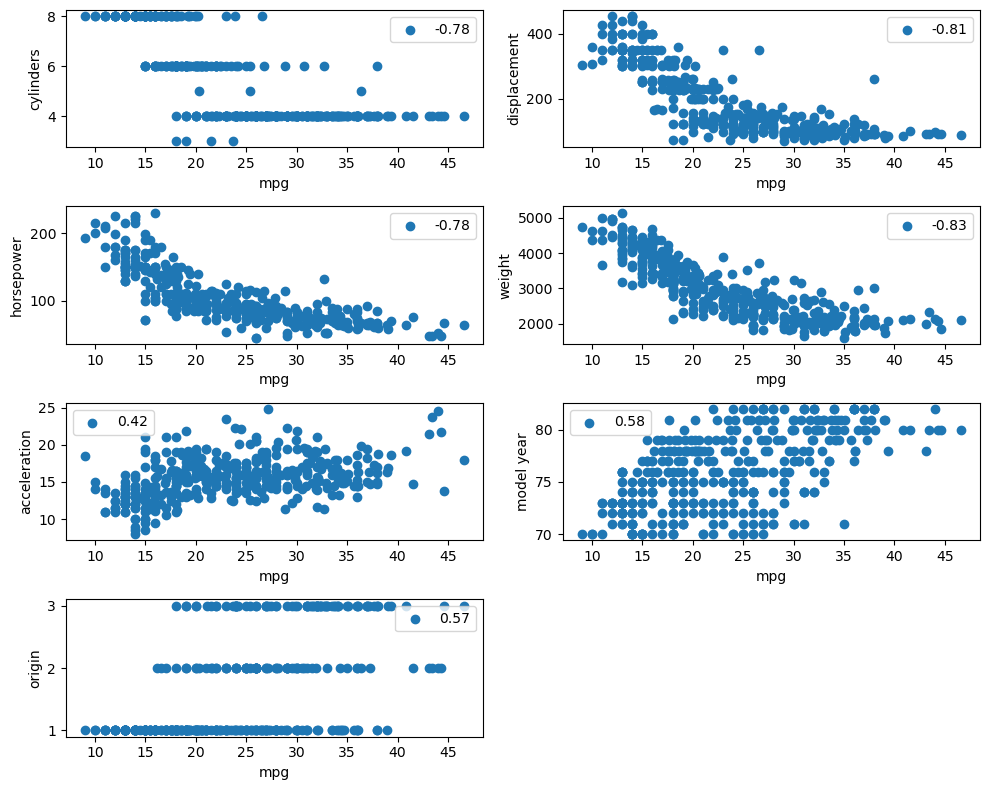

In [9]:
features = tempDF.columns[1:8]
print_features(4, 2, tempDF, 'mpg', list(features))

피쳐, 타겟 분리

In [10]:
# mpg 와 비선형 상관관계 : 'displacement', 'horsepower', 'weight', 'acceleration', 'model year'
selected_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'model year']
featureDF = tempDF[selected_features]
targetSR = tempDF['mpg']

훈련 데이터셋, 테스트 데이터셋 분리

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.3, random_state=2024)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((274, 5), (274,), (118, 5), (118,))

피쳐 스케일링

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)    # 훈련 데이터로 생성 (fit)

scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

고차 다항식 특성/피쳐로 확장

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False, interaction_only=True, degree=2)
# poly.get_feature_names_out()

# poly.fit(scaled_x_train)
# poly.get_feature_names_out()
poly_x_train = poly.fit_transform(scaled_x_train)
poly_x_test = poly.fit_transform(scaled_x_test)

In [14]:
# scaled_x_train.columns = ['displacement', 'horsepower', 'weight', 'acceleration', 'model year']
scaled_x_train

array([[-0.23173804, -0.51821862, -0.40365449, -0.1375    ,  0.83333333],
       [ 0.37279597,  0.16194332,  0.52524917,  0.2625    , -0.33333333],
       [-0.15617128,  0.03238866, -0.210299  , -0.2375    , -0.66666667],
       ...,
       [-0.14609572, -0.24291498, -0.24684385,  0.2625    , -0.33333333],
       [ 0.37279597,  0.16194332,  0.19833887,  0.2625    , -0.5       ],
       [ 0.84130982,  0.89068826,  1.08604651, -0.4875    , -0.33333333]])

테스트

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(poly_x_train, y_train)

lin_reg.score(poly_x_train, y_train), lin_reg.score(poly_x_test, y_test)

(0.8871846376751886, 0.8393121558070269)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = lin_reg.predict(poly_x_test)
r2_score = r2_score(y_test, y_pred)
print(f'R2: {r2_score}')

print(f'Mean absolute error; MAE: {mean_absolute_error(y_test, y_pred)}')

print(f'Mean squared error; MSE: {mean_squared_error(y_test, y_pred)}')

print(f'Root mean squared error; RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')


R2: 0.8393121558070269
Mean absolute error; MAE: 2.1686176192412643
Mean squared error; MSE: 10.126972741353196
Root mean squared error; RMSE: 3.1822904866390176
